<a href="https://colab.research.google.com/github/joeljose/audio_denoising/blob/main/spec_morph_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Noise Compensation using Spectrogram Morphological Filtering
In this project we try out image based morphological filtering to audio spectrograms for removing noise from audio signals. Regions of the spectrogram having high energy are estimated to be of more importance and likely to contain the original audio signal. The process of erosion can remove noise while dilation can then restore any erroneously removed signal regions. The combination of the two techniques results
in a non-linear, time-frequency filter. We then recreate the denoised audio from the processed spectrogram.

## Importing all the essential modules:

In [1]:
from scipy.ndimage import binary_erosion
from scipy.ndimage import binary_dilation
from scipy.io import wavfile
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import soundfile as sf


## Creating a noisy audio signal
First off let's create an audio signal with 3 musical tones.
 

In [2]:
fs=10000                                          # sampling frequency in Hz
notes=[837.31,1939.85,1054.94,1939.85,837.31]     # note frequencies in Hz
note_interval= 1                                  # duration of each note in seconds
song_time=len(notes)*note_interval                # Total duration of the song


dt=1/fs
t=np.arange(0,note_interval,dt)
new_t=np.arange(0,song_time,dt)

tones=[]

for fund_freq in notes:
  tones.append(np.sin(2 * np.pi * fund_freq * t)) # each note is a sine wave 

song = np.concatenate(tones)                      # add up all the notes to get our song



Now let's add some noise to the song we created

In [3]:
# creating a noise with the same dimension as input signal 

mu, sigma = 0.5, 1                               # mean and standard deviation of noise signal
noise = np.random.normal(mu, sigma, song.shape)  # generate noise signal using random function

noisy_song = song + noise                        # add the noise to the song to get noisy song

Let's hear the song

In [ ]:
Audio(song, rate=fs)

Now let's hear the noisy signal 

In [4]:
Audio(noisy_song, rate=fs)

##helper functions for creating plots and displaying them

In [5]:
def draw_spectrogram(time,freq,magnitude,title,cmap='inferno'):
  """
  Plots the spectrogram from the magnitude of the stft.
  """
  plt.rcParams['figure.figsize']=[10,5]
  plt.rcParams.update({'font.size':10})
  cmap = plt.get_cmap('inferno')
  plt.pcolormesh(time, freq, magnitude, shading='gouraud',cmap=cmap)
  plt.ylim([freq[1], freq[-1]])
  plt.title('Spectrogram of '+title)
  plt.ylabel('Frequency [Hz]')
  plt.xlabel('Time [sec]')
  plt.colorbar() 

def draw_timeseries(input_signal,time):
  """
  plots the audio signal
  """
  plt.rcParams['figure.figsize']=[10,5]
  plt.rcParams.update({'font.size':10})
  plt.plot(time,input_signal,color='c',linewidth=1.5,label="input")
  plt.xlim=(time[0],time[-1])
  plt.title('Signal')
  plt.ylabel('Amplitude')
  plt.xlabel('Time[sec]')


## Spectrograms of the song and noisy song we created.
We can create spectrograms of the audio signal by taking the STFT(short time fourier transform) of the signal and plotting just the magnitude of this complex valued function(Zxx).

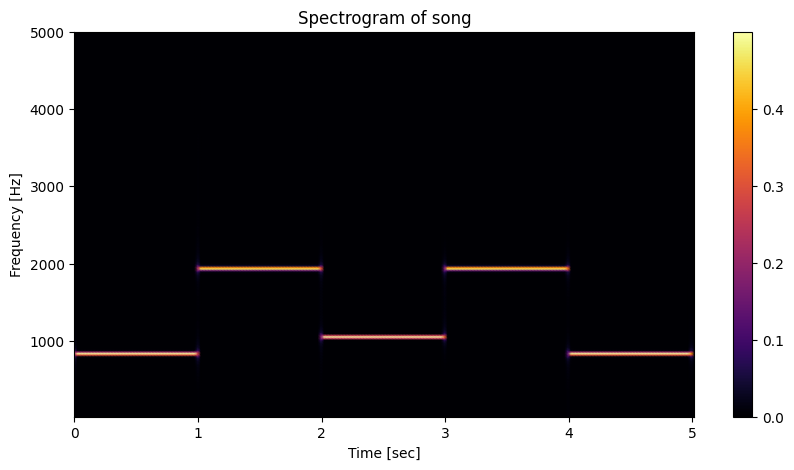

In [6]:
nperseg = 512                                             # no. of samples in a segment

freq, ti, Zxx = signal.stft(song, fs=fs, nperseg=nperseg) #STFT function

draw_spectrogram(ti,freq,np.abs(Zxx),'song')              # we use our helper function to draw the spectrogram

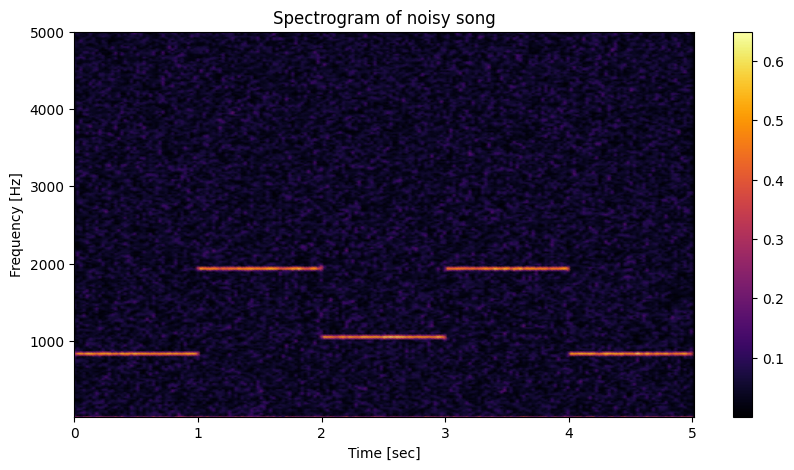

In [7]:
nperseg = 512

freq, ti, Zxx = signal.stft(noisy_song, fs=fs, nperseg=nperseg)

draw_spectrogram(ti,freq,np.abs(Zxx),'noisy song')

Zxx is a complex valued signal(stft of the audio signal) whose magnitude we plot as the spectrogram.
By comparing the spectrograms of the original and noisy audio signals, we see that if we can filter out just the bright parts, we can reconstruct the original without any of the noise.

## Denoise function
We need to make a function that takes in the complex valued Zxx and gives out the complex valued Rxx as the recovered stft signal, with which we can then do inverse stft to get our final recovered denoised audio signal.

There are 4 steps in the process:
* Create a grayscale image from the magnitude of Zxx.
* Apply binary thresholding.
* Apply morphological processing to get the mask image.
* Using this mask image we create Rxx.

In [8]:
def morph_denoise(Zxx,threshold,amp):
  
  zmax=(np.max(np.abs(Zxx)))
  
  gray_image=np.abs(Zxx)*(255/zmax)
  
  thresh_image=np.where(gray_image>=threshold,1,0)# binary thresholding

  mask_image = binary_erosion(thresh_image,iterations=1)
  mask_image = binary_dilation(mask_image,iterations=2)


  figure ,axis_arr = plt.subplots(1,3)
  plt.rcParams['figure.figsize']=[15,10]
  plt.rcParams.update({'font.size':10})
  axis_arr[0].set_title("grayscale spectrogram")
  axis_arr[0].imshow(gray_image,cmap=plt.cm.gray)
  axis_arr[1].set_title("After binary thresholding")
  axis_arr[1].imshow(thresh_image,cmap=plt.cm.gray)
  axis_arr[2].set_title("After Morphological filtering")
  axis_arr[2].imshow(mask_image,cmap=plt.cm.gray)
  Rxx = np.where(mask_image==1,Zxx*amp ,Zxx/amp)
  
  return Rxx


Now let's apply the denoise function on Zxx to get Rxx.

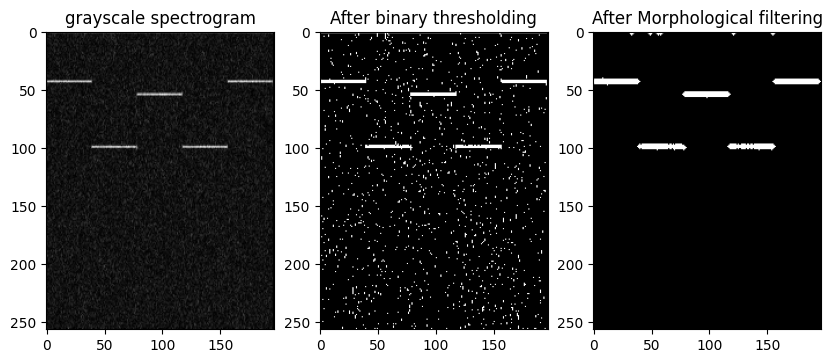

In [9]:
Rxx=morph_denoise(Zxx,threshold=40,amp=10)


The image we process looks different from the spectrogram because the axis are flipped(image indices start from 0 from the top). But that doesn't affect the processing.
 
Let's take a look at the spectrogram of the recovered signal.

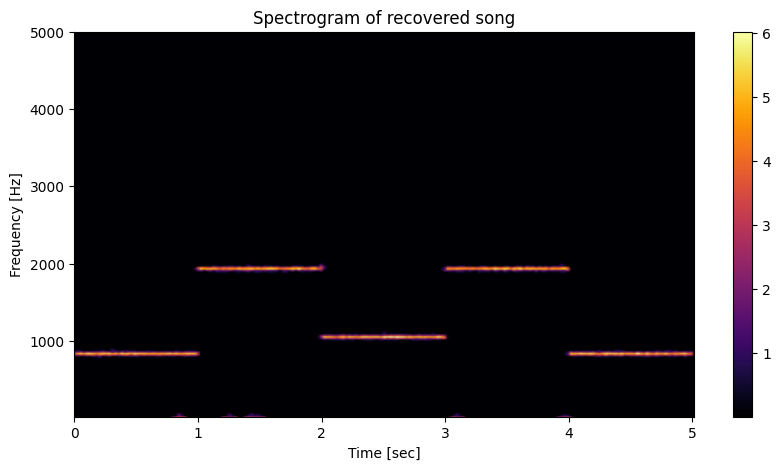

In [10]:
draw_spectrogram(ti,freq,np.abs(Rxx),'recovered song')

Now let's reconstruct the audio signal from Rxx by applying inverse short time fourier transform.

In [11]:
_, xrec = signal.istft(Rxx, fs)

Audio(xrec, rate=fs)

## Applications
This project was part of a bigger project called "Visual Mic", where we extract audio from motion due to vibrations caused by sound waves on materials.
Here is the link to the project: https://github.com/joeljose/Visual-Mic </br>  This denoising algorithm was effective in extracting out the signal from the noisy audio. First let me show you the audio which we got from visual mic.


Let's get the audio file from my github repository 

In [12]:
!wget https://github.com/joeljose/assets/raw/master/audio_denoising/visualmic.wav

'wget' is not recognized as an internal or external command,
operable program or batch file.


Now lets load the audio file, print details about it and also plot the audio waveform.

In [ ]:
noisy_signal,fs =librosa.load("visualmic.wav",sr=None)

n=len(noisy_signal)
dt=1/fs
tot_time=np.floor(n*dt)
print(f'Total playback time :{tot_time} seconds')
print(f'Total no. of samples :{n}')
print(f'Sampling frequency :{fs} Hz')


t=np.arange(0,tot_time,dt)

# Plot the signal 

draw_timeseries(noisy_signal,t)


Let's hear it

In [ ]:
Audio(noisy_signal,rate=fs)

Let's also look at it's spectrogram

In [ ]:
nperseg = 512

freq, ti, Zxx = signal.stft(noisy_signal, fs=fs, nperseg=nperseg)

draw_spectrogram(ti,freq,np.abs(Zxx),'noisy signal obtained from visual mic')

Now let's apply the denoise function on Zxx to get Rxx.

In [ ]:
Rxx=morph_denoise(Zxx,threshold=20,amp=10)


Let's take a look at the spectrogram of the recovered signal.

In [ ]:
draw_spectrogram(ti,freq,np.abs(Rxx),'recovered song')

Now let's reconstruct the audio signal from Rxx by applying inverse short time fourier transform.

In [ ]:
_, xrec = signal.istft(Rxx, fs)

Audio(xrec, rate=fs)

The reconstructed audio is a much more clear audio of "mary had a little lamb".
